In [1]:
!pip install -q insightface==0.7.3
!pip install -q onnxruntime-gpu
!pip install -q opencv-python-headless
!pip install -q scikit-learn
!pip install -q tqdm --upgrade

from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pickle
import os
from tqdm import tqdm
from collections import defaultdict
import json
import shutil
import warnings
warnings.filterwarnings('ignore')

VIDEO_PATH = '/content/drive/MyDrive/movie.mp4'
OUTPUT_DIR = '/content/drive/MyDrive/face_mapping_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

FRAME_SAMPLE_RATE = 30
MIN_FACE_SIZE = 30
SIMILARITY_THRESHOLD = 0.35
DBSCAN_EPS = 0.4
MIN_CLUSTER_SIZE = 3
TEST_FRAMES_COUNT = 150

print("Setup complete. Output directory:", OUTPUT_DIR)
print("Video path:", VIDEO_PATH)

print("\nInitializing InsightFace model (buffalo_l) on GPU...")

app = FaceAnalysis(
    name='buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(640, 640))

print("Model loaded successfully on GPU")
print("Available providers:", app.models['detection'].session.get_providers())

def extract_faces_from_video(video_path, sample_rate=FRAME_SAMPLE_RATE):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(f"\nVideo Info:")
    print(f"- Total frames: {total_frames}")
    print(f"- FPS: {fps:.2f}")
    print(f"- Duration: {total_frames/fps:.2f} seconds")

    all_faces = []
    frame_indices = []
    face_boxes = []

    frame_idx = 0
    frames_to_process = total_frames // sample_rate
    pbar = tqdm(total=frames_to_process, desc="Extracting faces")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % sample_rate == 0:
            faces = app.get(frame)

            for face in faces:
                bbox = face.bbox.astype(int)
                x1, y1, x2, y2 = bbox

                if (x2 - x1) < MIN_FACE_SIZE or (y2 - y1) < MIN_FACE_SIZE:
                    continue

                all_faces.append(face.embedding)
                frame_indices.append(frame_idx)
                face_boxes.append({
                    'frame_idx': frame_idx,
                    'bbox': bbox.tolist(),
                    'confidence': float(face.det_score)
                })

            pbar.update(1)

        frame_idx += 1

    cap.release()
    pbar.close()

    print(f"\nExtraction complete:")
    print(f"- Processed {frame_idx} frames")
    print(f"- Extracted {len(all_faces)} faces")

    return np.array(all_faces), frame_indices, face_boxes

print("\nStarting face extraction from video...")
embeddings, frame_indices, face_boxes = extract_faces_from_video(VIDEO_PATH)

def cluster_faces(embeddings, eps=DBSCAN_EPS, min_samples=MIN_CLUSTER_SIZE):
    print(f"\nClustering {len(embeddings)} faces...")

    similarity_matrix = cosine_similarity(embeddings)
    distance_matrix = 1 - similarity_matrix

    distance_matrix = np.clip(distance_matrix, 0, None)

    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clustering.fit_predict(distance_matrix)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Clustering complete:")
    print(f"- Found {n_clusters} unique characters")
    print(f"- Noise faces (not clustered): {n_noise}")

    return labels

labels = cluster_faces(embeddings)

def select_best_reference_faces(embeddings, labels, face_boxes):
    reference_faces = {}

    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        cluster_embeddings = embeddings[cluster_indices]
        cluster_boxes = [face_boxes[i] for i in cluster_indices]

        confidences = [box['confidence'] for box in cluster_boxes]
        best_idx = cluster_indices[np.argmax(confidences)]

        reference_faces[f"character_{label}"] = {
            'embedding': embeddings[best_idx],
            'frame_idx': face_boxes[best_idx]['frame_idx'],
            'bbox': face_boxes[best_idx]['bbox'],
            'confidence': face_boxes[best_idx]['confidence'],
            'cluster_size': len(cluster_indices)
        }

    print(f"\nSelected reference faces for {len(reference_faces)} characters")
    return reference_faces

reference_faces = select_best_reference_faces(embeddings, labels, face_boxes)

with open(f"{OUTPUT_DIR}/reference_faces.pkl", 'wb') as f:
    pickle.dump(reference_faces, f)

metadata = {
    'num_characters': len(reference_faces),
    'total_faces_extracted': len(embeddings),
    'video_path': VIDEO_PATH
}
with open(f"{OUTPUT_DIR}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n" + "="*70)
print("FACE MAPPING SUMMARY")
print("="*70)
for char_id, data in sorted(reference_faces.items()):
    print(f"{char_id}: {data['cluster_size']} appearances, "
          f"best at frame {data['frame_idx']}, "
          f"confidence {data['confidence']:.3f}")
print("="*70)

def extract_reference_images(video_path, reference_faces, output_dir):
    cap = cv2.VideoCapture(video_path)
    ref_images = {}

    print("\nExtracting reference face images...")

    for char_id, data in tqdm(reference_faces.items(), desc="Saving references"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, data['frame_idx'])
        ret, frame = cap.read()

        if ret:
            x1, y1, x2, y2 = data['bbox']
            face_crop = frame[y1:y2, x1:x2]
            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

            ref_path = f"{output_dir}/{char_id}_reference.jpg"
            Image.fromarray(face_crop).save(ref_path)
            ref_images[char_id] = face_crop

    cap.release()
    print(f"Extracted {len(ref_images)} reference images")
    return ref_images

reference_images = extract_reference_images(VIDEO_PATH, reference_faces, OUTPUT_DIR)

def generate_test_frames(video_path, num_frames=TEST_FRAMES_COUNT, output_dir=OUTPUT_DIR):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    test_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    test_frames_dir = f"{output_dir}/test_frames"
    os.makedirs(test_frames_dir, exist_ok=True)

    print(f"\nGenerating {num_frames} test frames...")
    saved_frames = []

    for idx in tqdm(test_indices, desc="Generating test frames"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_path = f"{test_frames_dir}/frame_{idx:06d}.jpg"
            cv2.imwrite(frame_path, frame)
            saved_frames.append((idx, frame_path, frame))

    cap.release()
    print(f"Test frames saved to {test_frames_dir}")
    return saved_frames

test_frames = generate_test_frames(VIDEO_PATH)

def match_faces_in_frame(frame, reference_faces, similarity_threshold=SIMILARITY_THRESHOLD):
    faces = app.get(frame)

    if len(faces) == 0:
        return []

    matched_faces = []

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        best_match = None
        best_similarity = -1

        for char_id, ref_data in reference_faces.items():
            ref_embedding = ref_data['embedding']
            similarity = cosine_similarity([embedding], [ref_embedding])[0][0]

            if similarity > best_similarity and similarity > similarity_threshold:
                best_similarity = similarity
                best_match = char_id

        matched_faces.append({
            'bbox': bbox.tolist(),
            'character_id': best_match,
            'confidence': float(face.det_score),
            'similarity': float(best_similarity) if best_match else 0.0
        })

    return matched_faces

print("\nMatching faces in test frames (using GPU)...")
frame_matches = []

for frame_idx, frame_path, frame in tqdm(test_frames, desc="Processing test frames"):
    matches = match_faces_in_frame(frame, reference_faces)
    frame_matches.append({
        'frame_idx': frame_idx,
        'frame_path': frame_path,
        'matches': matches
    })

print(f"Processed {len(frame_matches)} frames")

matches_output = []
for fm in frame_matches:
    matches_output.append({
        'frame_idx': fm['frame_idx'],
        'matches': fm['matches']
    })

with open(f"{OUTPUT_DIR}/frame_matches.json", 'w') as f:
    json.dump(matches_output, f, indent=2)

def create_visualization(frame, matches, reference_images, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame_rgb.shape[:2]

    frame_annotated = frame_rgb.copy()
    pil_frame = Image.fromarray(frame_annotated)
    draw = ImageDraw.Draw(pil_frame)

    detected_chars = []

    for match in matches:
        x1, y1, x2, y2 = match['bbox']
        char_id = match['character_id']

        if char_id:
            draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
            detected_chars.append(char_id)

    frame_annotated = np.array(pil_frame)

    if len(matches) == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: NO FACES FOUND", fontsize=16, color='red', weight='bold')
        ax.axis('off')
        ax.text(0.5, 0.5, 'NO FACES FOUND',
                transform=ax.transAxes, fontsize=30, color='red',
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return fig

    num_detected = len(detected_chars)

    if num_detected == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: Faces detected but not matched",
                     fontsize=14, weight='bold')
        ax.axis('off')
        return fig

    cols = num_detected + 1
    fig_width = 4 * cols
    fig, axes = plt.subplots(1, cols, figsize=(fig_width, 6))

    if cols == 2:
        axes = [axes[0], axes[1]]

    axes[0].imshow(frame_annotated)
    axes[0].set_title("Input Frame", fontsize=14, weight='bold')
    axes[0].text(0.5, -0.05, 'im', transform=axes[0].transAxes,
                 fontsize=10, ha='center')
    axes[0].axis('off')

    for idx, char_id in enumerate(detected_chars, 1):
        if char_id in reference_images:
            axes[idx].imshow(reference_images[char_id])
            axes[idx].set_title(char_id.replace('character_', 'Character '),
                                fontsize=12, weight='bold')
            axes[idx].text(0.5, -0.05, 'ref', transform=axes[idx].transAxes,
                           fontsize=10, ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    return fig

viz_dir = f"{OUTPUT_DIR}/visualizations"
os.makedirs(viz_dir, exist_ok=True)

print("\nCreating visualizations...")
for fm in tqdm(frame_matches, desc="Generating visualizations"):
    frame_idx = fm['frame_idx']
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, frame_idx)

    output_path = f"{viz_dir}/frame_{frame_idx:06d}_viz.jpg"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Visualizations saved to {viz_dir}")

def generate_summary_report(frame_matches, reference_faces, output_dir):
    total_frames = len(frame_matches)
    frames_with_faces = sum(1 for fm in frame_matches if len(fm['matches']) > 0)
    frames_no_faces = total_frames - frames_with_faces

    frames_with_matches = sum(1 for fm in frame_matches
                              if any(m['character_id'] for m in fm['matches']))

    char_appearances = defaultdict(int)
    for fm in frame_matches:
        detected_chars = set()
        for match in fm['matches']:
            if match['character_id']:
                detected_chars.add(match['character_id'])
        for char in detected_chars:
            char_appearances[char] += 1

    report = f"""
{'='*70}
FACE MATCHING SUMMARY REPORT
{'='*70}

VIDEO ANALYSIS:
- Total test frames processed: {total_frames}
- Frames with detected faces: {frames_with_faces} ({frames_with_faces/total_frames*100:.1f}%)
- Frames with matched characters: {frames_with_matches} ({frames_with_matches/total_frames*100:.1f}%)
- Frames with no faces: {frames_no_faces} ({frames_no_faces/total_frames*100:.1f}%)

CHARACTER REFERENCE DATABASE:
- Total unique characters: {len(reference_faces)}

CHARACTER APPEARANCES IN TEST FRAMES:
"""

    for char_id in sorted(char_appearances.keys()):
        count = char_appearances[char_id]
        percentage = count / total_frames * 100
        report += f"- {char_id}: {count} frames ({percentage:.1f}%)\n"

    report += f"\n{'='*70}\n"

    print(report)

    with open(f"{output_dir}/summary_report.txt", 'w') as f:
        f.write(report)

    return report

summary = generate_summary_report(frame_matches, reference_faces, OUTPUT_DIR)

print("\nCreating ZIP file for download...")

zip_base_path = '/content/face_mapping_results'
zip_path = f'{zip_base_path}.zip'

if os.path.exists(zip_path):
    os.remove(zip_path)

shutil.make_archive(zip_base_path, 'zip', OUTPUT_DIR)

zip_size_mb = os.path.getsize(zip_path) / (1024 * 1024)

print("\n" + "="*70)
print("PIPELINE COMPLETE")
print("="*70)
print(f"\nOutput includes:")
print(f"- Reference face images for {len(reference_faces)} characters")
print(f"- {len(frame_matches)} test frame visualizations")
print(f"- JSON file with all face matches")
print(f"- Summary report")
print(f"\nZIP file size: {zip_size_mb:.2f} MB")
print(f"ZIP file location: {zip_path}")
print("\nDownloading ZIP file now...")
print("="*70)

from google.colab import files
files.download(zip_path)

print("\nDownload complete! Check your downloads folder.")

print("\nDisplaying sample visualizations...")

sample_indices = np.linspace(0, len(frame_matches)-1, min(5, len(frame_matches)), dtype=int)

for idx in sample_indices:
    fm = frame_matches[idx]
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, fm['frame_idx'])
    plt.show()
    plt.close()

print(f"\nSample visualizations displayed above")
print(f"All {len(frame_matches)} visualizations saved in ZIP file")
print("\nPipeline execution complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 31.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00
Mounted at /content/drive
Setup complete. Output directory: /content/drive/MyDrive/face_mapping_output
Video path: /content/drive/MyDrive/movie.mp4

Initializing InsightFace model (buffalo_l) on GPU...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 107168.04KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

Extracting faces: 7867it [09:53, 13.27it/s]                          



Extraction complete:
- Processed 235984 frames
- Extracted 13459 faces

Clustering 13459 faces...
Clustering complete:
- Found 485 unique characters
- Noise faces (not clustered): 2456

Selected reference faces for 485 characters

FACE MAPPING SUMMARY
character_0: 476 appearances, best at frame 13500, confidence 0.901
character_1: 130 appearances, best at frame 42690, confidence 0.906
character_10: 1204 appearances, best at frame 192990, confidence 0.917
character_100: 5 appearances, best at frame 32910, confidence 0.535
character_101: 4 appearances, best at frame 33450, confidence 0.738
character_102: 8 appearances, best at frame 33780, confidence 0.787
character_103: 9 appearances, best at frame 34560, confidence 0.704
character_104: 4 appearances, best at frame 37020, confidence 0.842
character_105: 182 appearances, best at frame 155220, confidence 0.906
character_106: 10 appearances, best at frame 37530, confidence 0.877
character_107: 4 appearances, best at frame 39750, confidenc

Saving references:   1%|          | 4/485 [00:03<07:10,  1.12it/s]


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [2]:
!pip install -q insightface==0.7.3
!pip install -q onnxruntime-gpu
!pip install -q opencv-python-headless
!pip install -q scikit-learn
!pip install -q tqdm --upgrade

from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pickle
import os
from tqdm import tqdm
from collections import defaultdict
import json
import shutil
import warnings
warnings.filterwarnings('ignore')

VIDEO_PATH = '/content/drive/MyDrive/movie.mp4'
OUTPUT_DIR = '/content/drive/MyDrive/face_mapping_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

FRAME_SAMPLE_RATE = 30
MIN_FACE_SIZE = 30
SIMILARITY_THRESHOLD = 0.35
DBSCAN_EPS = 0.4
MIN_CLUSTER_SIZE = 3
TEST_FRAMES_COUNT = 150

print("Setup complete. Output directory:", OUTPUT_DIR)
print("Video path:", VIDEO_PATH)

print("\nInitializing InsightFace model (buffalo_l) on GPU...")

app = FaceAnalysis(
    name='buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(640, 640))

print("Model loaded successfully on GPU")
print("Available providers:", app.models['detection'].session.get_providers())

def extract_faces_from_video(video_path, sample_rate=FRAME_SAMPLE_RATE):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"\nVideo Info:")
    print(f"- Total frames: {total_frames}")
    print(f"- FPS: {fps:.2f}")
    print(f"- Resolution: {width}x{height}")
    print(f"- Duration: {total_frames/fps:.2f} seconds")

    all_faces = []
    frame_indices = []
    face_boxes = []

    frame_idx = 0
    frames_to_process = total_frames // sample_rate
    pbar = tqdm(total=frames_to_process, desc="Extracting faces")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % sample_rate == 0:
            faces = app.get(frame)

            for face in faces:
                bbox = face.bbox.astype(int)
                x1, y1, x2, y2 = bbox

                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(width, x2)
                y2 = min(height, y2)

                if (x2 - x1) < MIN_FACE_SIZE or (y2 - y1) < MIN_FACE_SIZE:
                    continue

                all_faces.append(face.embedding)
                frame_indices.append(frame_idx)
                face_boxes.append({
                    'frame_idx': frame_idx,
                    'bbox': [x1, y1, x2, y2],
                    'confidence': float(face.det_score)
                })

            pbar.update(1)

        frame_idx += 1

    cap.release()
    pbar.close()

    print(f"\nExtraction complete:")
    print(f"- Processed {frame_idx} frames")
    print(f"- Extracted {len(all_faces)} faces")

    return np.array(all_faces), frame_indices, face_boxes

print("\nStarting face extraction from video...")
embeddings, frame_indices, face_boxes = extract_faces_from_video(VIDEO_PATH)

def cluster_faces(embeddings, eps=DBSCAN_EPS, min_samples=MIN_CLUSTER_SIZE):
    print(f"\nClustering {len(embeddings)} faces...")

    similarity_matrix = cosine_similarity(embeddings)
    distance_matrix = 1 - similarity_matrix

    distance_matrix = np.clip(distance_matrix, 0, None)

    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clustering.fit_predict(distance_matrix)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Clustering complete:")
    print(f"- Found {n_clusters} unique characters")
    print(f"- Noise faces (not clustered): {n_noise}")

    return labels

labels = cluster_faces(embeddings)

def select_best_reference_faces(embeddings, labels, face_boxes):
    reference_faces = {}

    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        cluster_embeddings = embeddings[cluster_indices]
        cluster_boxes = [face_boxes[i] for i in cluster_indices]

        confidences = [box['confidence'] for box in cluster_boxes]
        best_idx = cluster_indices[np.argmax(confidences)]

        reference_faces[f"character_{label}"] = {
            'embedding': embeddings[best_idx],
            'frame_idx': face_boxes[best_idx]['frame_idx'],
            'bbox': face_boxes[best_idx]['bbox'],
            'confidence': face_boxes[best_idx]['confidence'],
            'cluster_size': len(cluster_indices)
        }

    print(f"\nSelected reference faces for {len(reference_faces)} characters")
    return reference_faces

reference_faces = select_best_reference_faces(embeddings, labels, face_boxes)

with open(f"{OUTPUT_DIR}/reference_faces.pkl", 'wb') as f:
    pickle.dump(reference_faces, f)

metadata = {
    'num_characters': len(reference_faces),
    'total_faces_extracted': len(embeddings),
    'video_path': VIDEO_PATH
}
with open(f"{OUTPUT_DIR}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n" + "="*70)
print("FACE MAPPING SUMMARY")
print("="*70)
for char_id, data in sorted(reference_faces.items()):
    print(f"{char_id}: {data['cluster_size']} appearances, "
          f"best at frame {data['frame_idx']}, "
          f"confidence {data['confidence']:.3f}")
print("="*70)

def extract_reference_images(video_path, reference_faces, output_dir):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    ref_images = {}

    print("\nExtracting reference face images...")

    for char_id, data in tqdm(reference_faces.items(), desc="Saving references"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, data['frame_idx'])
        ret, frame = cap.read()

        if ret:
            x1, y1, x2, y2 = data['bbox']

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            if x2 <= x1 or y2 <= y1:
                continue

            face_crop = frame[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue

            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

            ref_path = f"{output_dir}/{char_id}_reference.jpg"
            Image.fromarray(face_crop).save(ref_path)
            ref_images[char_id] = face_crop

    cap.release()
    print(f"Extracted {len(ref_images)} reference images")
    return ref_images

reference_images = extract_reference_images(VIDEO_PATH, reference_faces, OUTPUT_DIR)

def generate_test_frames(video_path, num_frames=TEST_FRAMES_COUNT, output_dir=OUTPUT_DIR):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    test_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    test_frames_dir = f"{output_dir}/test_frames"
    os.makedirs(test_frames_dir, exist_ok=True)

    print(f"\nGenerating {num_frames} test frames...")
    saved_frames = []

    for idx in tqdm(test_indices, desc="Generating test frames"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_path = f"{test_frames_dir}/frame_{idx:06d}.jpg"
            cv2.imwrite(frame_path, frame)
            saved_frames.append((idx, frame_path, frame))

    cap.release()
    print(f"Test frames saved to {test_frames_dir}")
    return saved_frames

test_frames = generate_test_frames(VIDEO_PATH)

def match_faces_in_frame(frame, reference_faces, similarity_threshold=SIMILARITY_THRESHOLD):
    faces = app.get(frame)

    if len(faces) == 0:
        return []

    matched_faces = []

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        best_match = None
        best_similarity = -1

        for char_id, ref_data in reference_faces.items():
            ref_embedding = ref_data['embedding']
            similarity = cosine_similarity([embedding], [ref_embedding])[0][0]

            if similarity > best_similarity and similarity > similarity_threshold:
                best_similarity = similarity
                best_match = char_id

        matched_faces.append({
            'bbox': bbox.tolist(),
            'character_id': best_match,
            'confidence': float(face.det_score),
            'similarity': float(best_similarity) if best_match else 0.0
        })

    return matched_faces

print("\nMatching faces in test frames (using GPU)...")
frame_matches = []

for frame_idx, frame_path, frame in tqdm(test_frames, desc="Processing test frames"):
    matches = match_faces_in_frame(frame, reference_faces)
    frame_matches.append({
        'frame_idx': frame_idx,
        'frame_path': frame_path,
        'matches': matches
    })

print(f"Processed {len(frame_matches)} frames")

matches_output = []
for fm in frame_matches:
    matches_output.append({
        'frame_idx': fm['frame_idx'],
        'matches': fm['matches']
    })

with open(f"{OUTPUT_DIR}/frame_matches.json", 'w') as f:
    json.dump(matches_output, f, indent=2)

def create_visualization(frame, matches, reference_images, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame_rgb.shape[:2]

    frame_annotated = frame_rgb.copy()
    pil_frame = Image.fromarray(frame_annotated)
    draw = ImageDraw.Draw(pil_frame)

    detected_chars = []

    for match in matches:
        x1, y1, x2, y2 = match['bbox']
        char_id = match['character_id']

        if char_id:
            draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
            detected_chars.append(char_id)

    frame_annotated = np.array(pil_frame)

    if len(matches) == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: NO FACES FOUND", fontsize=16, color='red', weight='bold')
        ax.axis('off')
        ax.text(0.5, 0.5, 'NO FACES FOUND',
                transform=ax.transAxes, fontsize=30, color='red',
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return fig

    num_detected = len(detected_chars)

    if num_detected == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: Faces detected but not matched",
                     fontsize=14, weight='bold')
        ax.axis('off')
        return fig

    cols = num_detected + 1
    fig_width = 4 * cols
    fig, axes = plt.subplots(1, cols, figsize=(fig_width, 6))

    if cols == 2:
        axes = [axes[0], axes[1]]

    axes[0].imshow(frame_annotated)
    axes[0].set_title("Input Frame", fontsize=14, weight='bold')
    axes[0].text(0.5, -0.05, 'im', transform=axes[0].transAxes,
                 fontsize=10, ha='center')
    axes[0].axis('off')

    for idx, char_id in enumerate(detected_chars, 1):
        if char_id in reference_images:
            axes[idx].imshow(reference_images[char_id])
            axes[idx].set_title(char_id.replace('character_', 'Character '),
                                fontsize=12, weight='bold')
            axes[idx].text(0.5, -0.05, 'ref', transform=axes[idx].transAxes,
                           fontsize=10, ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    return fig

viz_dir = f"{OUTPUT_DIR}/visualizations"
os.makedirs(viz_dir, exist_ok=True)

print("\nCreating visualizations...")
for fm in tqdm(frame_matches, desc="Generating visualizations"):
    frame_idx = fm['frame_idx']
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, frame_idx)

    output_path = f"{viz_dir}/frame_{frame_idx:06d}_viz.jpg"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Visualizations saved to {viz_dir}")

def generate_summary_report(frame_matches, reference_faces, output_dir):
    total_frames = len(frame_matches)
    frames_with_faces = sum(1 for fm in frame_matches if len(fm['matches']) > 0)
    frames_no_faces = total_frames - frames_with_faces

    frames_with_matches = sum(1 for fm in frame_matches
                              if any(m['character_id'] for m in fm['matches']))

    char_appearances = defaultdict(int)
    for fm in frame_matches:
        detected_chars = set()
        for match in fm['matches']:
            if match['character_id']:
                detected_chars.add(match['character_id'])
        for char in detected_chars:
            char_appearances[char] += 1

    report = f"""
{'='*70}
FACE MATCHING SUMMARY REPORT
{'='*70}

VIDEO ANALYSIS:
- Total test frames processed: {total_frames}
- Frames with detected faces: {frames_with_faces} ({frames_with_faces/total_frames*100:.1f}%)
- Frames with matched characters: {frames_with_matches} ({frames_with_matches/total_frames*100:.1f}%)
- Frames with no faces: {frames_no_faces} ({frames_no_faces/total_frames*100:.1f}%)

CHARACTER REFERENCE DATABASE:
- Total unique characters: {len(reference_faces)}

CHARACTER APPEARANCES IN TEST FRAMES:
"""

    for char_id in sorted(char_appearances.keys()):
        count = char_appearances[char_id]
        percentage = count / total_frames * 100
        report += f"- {char_id}: {count} frames ({percentage:.1f}%)\n"

    report += f"\n{'='*70}\n"

    print(report)

    with open(f"{output_dir}/summary_report.txt", 'w') as f:
        f.write(report)

    return report

summary = generate_summary_report(frame_matches, reference_faces, OUTPUT_DIR)

print("\nCreating ZIP file for download...")

zip_base_path = '/content/face_mapping_results'
zip_path = f'{zip_base_path}.zip'

if os.path.exists(zip_path):
    os.remove(zip_path)

shutil.make_archive(zip_base_path, 'zip', OUTPUT_DIR)

zip_size_mb = os.path.getsize(zip_path) / (1024 * 1024)

print("\n" + "="*70)
print("PIPELINE COMPLETE")
print("="*70)
print(f"\nOutput includes:")
print(f"- Reference face images for {len(reference_faces)} characters")
print(f"- {len(frame_matches)} test frame visualizations")
print(f"- JSON file with all face matches")
print(f"- Summary report")
print(f"\nZIP file size: {zip_size_mb:.2f} MB")
print(f"ZIP file location: {zip_path}")
print("\nDownloading ZIP file now...")
print("="*70)

from google.colab import files
files.download(zip_path)

print("\nDownload complete! Check your downloads folder.")

print("\nDisplaying sample visualizations...")

sample_indices = np.linspace(0, len(frame_matches)-1, min(5, len(frame_matches)), dtype=int)

for idx in sample_indices:
    fm = frame_matches[idx]
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, fm['frame_idx'])
    plt.show()
    plt.close()

print(f"\nSample visualizations displayed above")
print(f"All {len(frame_matches)} visualizations saved in ZIP file")
print("\nPipeline execution complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete. Output directory: /content/drive/MyDrive/face_mapping_output
Video path: /content/drive/MyDrive/movie.mp4

Initializing InsightFace model (buffalo_l) on GPU...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'd

Extracting faces: 7867it [09:59, 13.12it/s]                          



Extraction complete:
- Processed 235984 frames
- Extracted 13457 faces

Clustering 13457 faces...
Clustering complete:
- Found 485 unique characters
- Noise faces (not clustered): 2455

Selected reference faces for 485 characters

FACE MAPPING SUMMARY
character_0: 476 appearances, best at frame 13500, confidence 0.901
character_1: 130 appearances, best at frame 42690, confidence 0.906
character_10: 1204 appearances, best at frame 192990, confidence 0.917
character_100: 5 appearances, best at frame 32910, confidence 0.535
character_101: 4 appearances, best at frame 33450, confidence 0.738
character_102: 8 appearances, best at frame 33780, confidence 0.787
character_103: 9 appearances, best at frame 34560, confidence 0.704
character_104: 4 appearances, best at frame 37020, confidence 0.842
character_105: 182 appearances, best at frame 155220, confidence 0.906
character_106: 10 appearances, best at frame 37530, confidence 0.877
character_107: 4 appearances, best at frame 39750, confidenc

Saving references: 100%|██████████| 485/485 [07:17<00:00,  1.11it/s]


Extracted 485 reference images

Generating 150 test frames...


Generating test frames: 100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


Test frames saved to /content/drive/MyDrive/face_mapping_output/test_frames

Matching faces in test frames (using GPU)...


Processing test frames: 100%|██████████| 150/150 [00:58<00:00,  2.58it/s]


Processed 150 frames


TypeError: Object of type int64 is not JSON serializable

✓ JSON file saved successfully!

Creating visualizations...


Generating visualizations: 100%|██████████| 150/150 [02:38<00:00,  1.06s/it]


Visualizations saved to /content/drive/MyDrive/face_mapping_output/visualizations

FACE MATCHING SUMMARY REPORT

VIDEO ANALYSIS:
- Total test frames processed: 150
- Frames with detected faces: 133 (88.7%)
- Frames with matched characters: 127 (84.7%)
- Frames with no faces: 17 (11.3%)

CHARACTER REFERENCE DATABASE:
- Total unique characters: 485

CHARACTER APPEARANCES IN TEST FRAMES:
- character_0: 12 frames (8.0%)
- character_1: 1 frames (0.7%)
- character_10: 24 frames (16.0%)
- character_100: 3 frames (2.0%)
- character_104: 2 frames (1.3%)
- character_105: 4 frames (2.7%)
- character_106: 1 frames (0.7%)
- character_108: 1 frames (0.7%)
- character_109: 1 frames (0.7%)
- character_111: 1 frames (0.7%)
- character_113: 1 frames (0.7%)
- character_123: 3 frames (2.0%)
- character_129: 1 frames (0.7%)
- character_131: 2 frames (1.3%)
- character_132: 1 frames (0.7%)
- character_137: 1 frames (0.7%)
- character_138: 1 frames (0.7%)
- character_14: 1 frames (0.7%)
- character_141: 2 fr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download complete! Check your downloads folder.

Displaying sample visualizations...


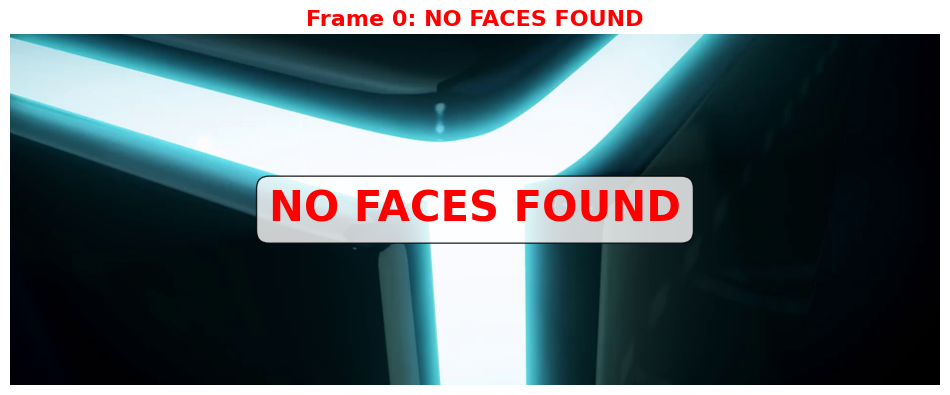

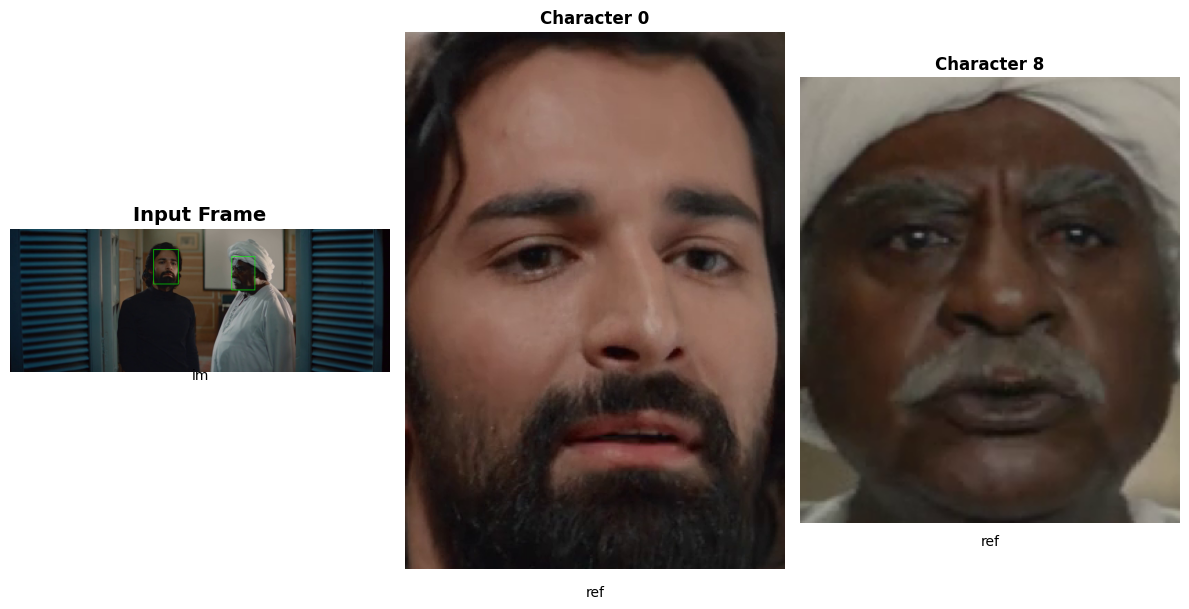

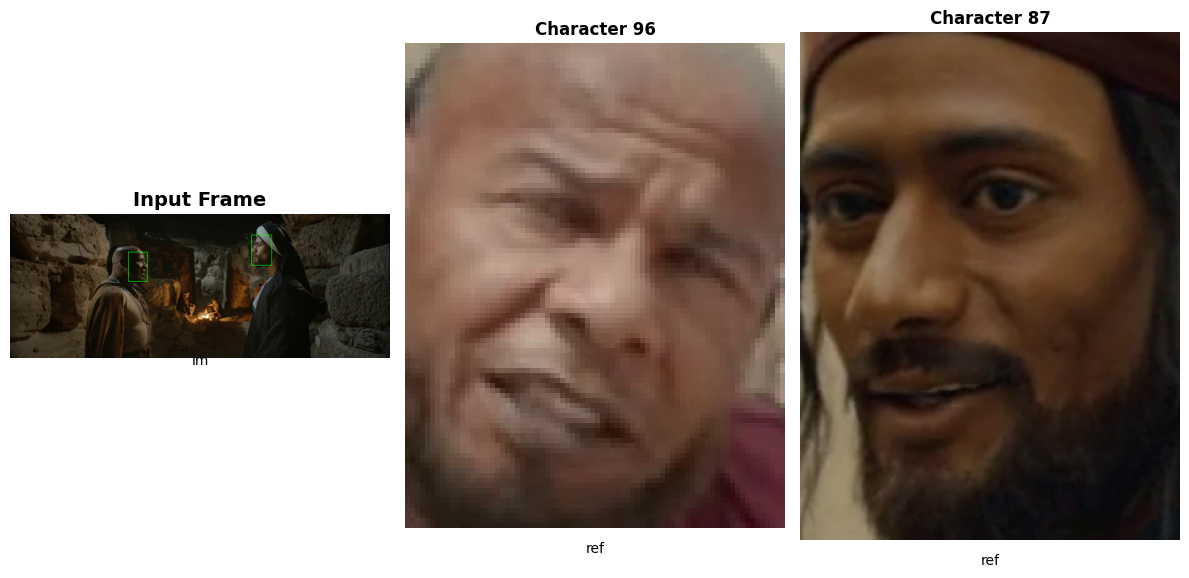

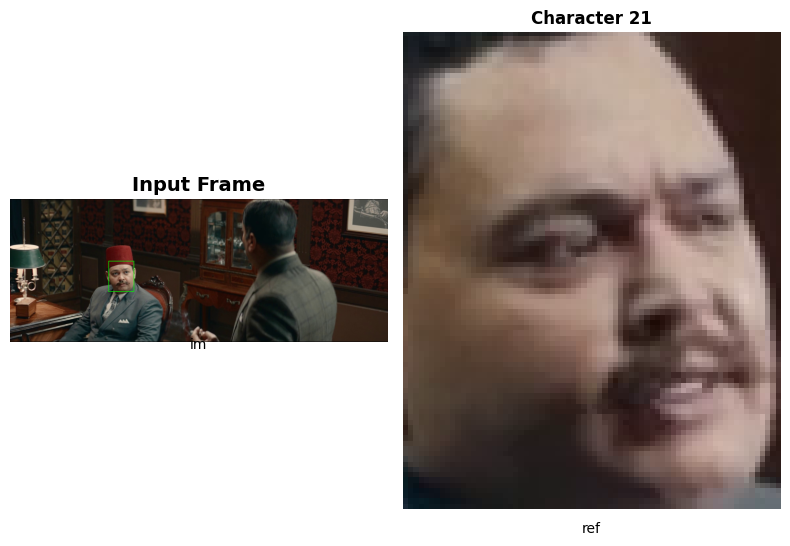

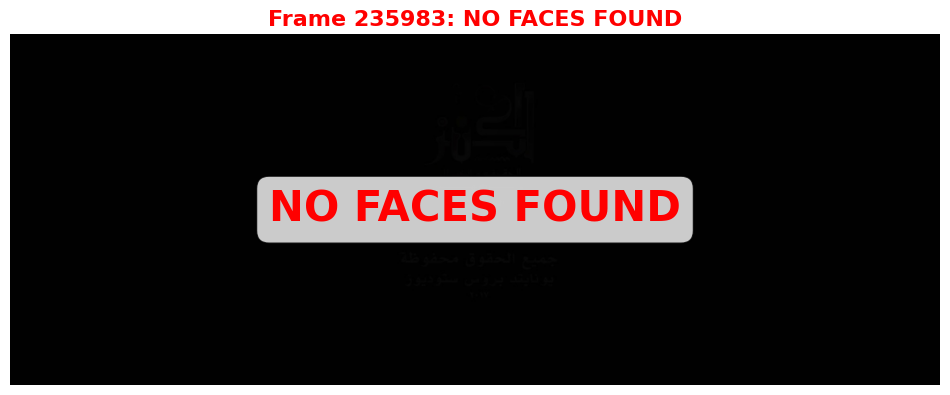


Sample visualizations displayed above
All 150 visualizations saved in ZIP file

Pipeline execution complete!


In [3]:

# Just run this cell after the error

import json
import numpy as np


matches_output = []
for fm in frame_matches:
    matches_output.append({
        'frame_idx': int(fm['frame_idx']),
        'matches': fm['matches']
    })

with open(f"{OUTPUT_DIR}/frame_matches.json", 'w') as f:
    json.dump(matches_output, f, indent=2)

print("✓ JSON file saved successfully!")

def create_visualization(frame, matches, reference_images, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame_rgb.shape[:2]

    frame_annotated = frame_rgb.copy()
    pil_frame = Image.fromarray(frame_annotated)
    draw = ImageDraw.Draw(pil_frame)

    detected_chars = []

    for match in matches:
        x1, y1, x2, y2 = match['bbox']
        char_id = match['character_id']

        if char_id:
            draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
            detected_chars.append(char_id)

    frame_annotated = np.array(pil_frame)

    if len(matches) == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: NO FACES FOUND", fontsize=16, color='red', weight='bold')
        ax.axis('off')
        ax.text(0.5, 0.5, 'NO FACES FOUND',
                transform=ax.transAxes, fontsize=30, color='red',
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return fig

    num_detected = len(detected_chars)

    if num_detected == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: Faces detected but not matched",
                     fontsize=14, weight='bold')
        ax.axis('off')
        return fig

    cols = num_detected + 1
    fig_width = 4 * cols
    fig, axes = plt.subplots(1, cols, figsize=(fig_width, 6))

    if cols == 2:
        axes = [axes[0], axes[1]]

    axes[0].imshow(frame_annotated)
    axes[0].set_title("Input Frame", fontsize=14, weight='bold')
    axes[0].text(0.5, -0.05, 'im', transform=axes[0].transAxes,
                 fontsize=10, ha='center')
    axes[0].axis('off')

    for idx, char_id in enumerate(detected_chars, 1):
        if char_id in reference_images:
            axes[idx].imshow(reference_images[char_id])
            axes[idx].set_title(char_id.replace('character_', 'Character '),
                                fontsize=12, weight='bold')
            axes[idx].text(0.5, -0.05, 'ref', transform=axes[idx].transAxes,
                           fontsize=10, ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    return fig


viz_dir = f"{OUTPUT_DIR}/visualizations"
os.makedirs(viz_dir, exist_ok=True)

print("\nCreating visualizations...")
for fm in tqdm(frame_matches, desc="Generating visualizations"):
    frame_idx = fm['frame_idx']
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, frame_idx)

    output_path = f"{viz_dir}/frame_{int(frame_idx):06d}_viz.jpg"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Visualizations saved to {viz_dir}")


def generate_summary_report(frame_matches, reference_faces, output_dir):
    from collections import defaultdict

    total_frames = len(frame_matches)
    frames_with_faces = sum(1 for fm in frame_matches if len(fm['matches']) > 0)
    frames_no_faces = total_frames - frames_with_faces

    frames_with_matches = sum(1 for fm in frame_matches
                              if any(m['character_id'] for m in fm['matches']))

    char_appearances = defaultdict(int)
    for fm in frame_matches:
        detected_chars = set()
        for match in fm['matches']:
            if match['character_id']:
                detected_chars.add(match['character_id'])
        for char in detected_chars:
            char_appearances[char] += 1

    report = f"""
{'='*70}
FACE MATCHING SUMMARY REPORT
{'='*70}

VIDEO ANALYSIS:
- Total test frames processed: {total_frames}
- Frames with detected faces: {frames_with_faces} ({frames_with_faces/total_frames*100:.1f}%)
- Frames with matched characters: {frames_with_matches} ({frames_with_matches/total_frames*100:.1f}%)
- Frames with no faces: {frames_no_faces} ({frames_no_faces/total_frames*100:.1f}%)

CHARACTER REFERENCE DATABASE:
- Total unique characters: {len(reference_faces)}

CHARACTER APPEARANCES IN TEST FRAMES:
"""

    for char_id in sorted(char_appearances.keys()):
        count = char_appearances[char_id]
        percentage = count / total_frames * 100
        report += f"- {char_id}: {count} frames ({percentage:.1f}%)\n"

    report += f"\n{'='*70}\n"

    print(report)

    with open(f"{output_dir}/summary_report.txt", 'w') as f:
        f.write(report)

    return report

summary = generate_summary_report(frame_matches, reference_faces, OUTPUT_DIR)


print("\nCreating ZIP file for download...")
import shutil

zip_base_path = '/content/face_mapping_results'
zip_path = f'{zip_base_path}.zip'

if os.path.exists(zip_path):
    os.remove(zip_path)

shutil.make_archive(zip_base_path, 'zip', OUTPUT_DIR)

zip_size_mb = os.path.getsize(zip_path) / (1024 * 1024)

print("\n" + "="*70)
print("PIPELINE COMPLETE")
print("="*70)
print(f"\nOutput includes:")
print(f"- Reference face images for {len(reference_faces)} characters")
print(f"- {len(frame_matches)} test frame visualizations")
print(f"- JSON file with all face matches")
print(f"- Summary report")
print(f"\nZIP file size: {zip_size_mb:.2f} MB")
print(f"ZIP file location: {zip_path}")
print("\nDownloading ZIP file now...")
print("="*70)

from google.colab import files
files.download(zip_path)

print("\nDownload complete! Check your downloads folder.")


print("\nDisplaying sample visualizations...")

sample_indices = np.linspace(0, len(frame_matches)-1, min(5, len(frame_matches)), dtype=int)

for idx in sample_indices:
    fm = frame_matches[idx]
    frame = cv2.imread(fm['frame_path'])
    matches = fm['matches']

    fig = create_visualization(frame, matches, reference_images, fm['frame_idx'])
    plt.show()
    plt.close()

print(f"\nSample visualizations displayed above")
print(f"All {len(frame_matches)} visualizations saved in ZIP file")
print("\nPipeline execution complete!")

In [4]:

!pip install -q insightface==0.7.3
!pip install -q onnxruntime-gpu
!pip install -q opencv-python-headless
!pip install -q scikit-learn
!pip install -q gradio
!pip install -q matplotlib
!pip install -q pillow


from google.colab import drive
drive.mount('/content/drive')

import gradio as gr
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pickle
import os
import json
import shutil
import warnings
from collections import defaultdict
import tempfile
import zipfile

warnings.filterwarnings('ignore')

MIN_FACE_SIZE = 30
SIMILARITY_THRESHOLD = 0.35
DBSCAN_EPS = 0.4
MIN_CLUSTER_SIZE = 3
FRAME_SAMPLE_RATE = 30


print("Initializing InsightFace model...")
app = FaceAnalysis(
    name='buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(640, 640))
print("Model loaded successfully")
print("Available providers:", app.models['detection'].session.get_providers())


def extract_faces_from_video(video_path, sample_rate, progress=gr.Progress()):
    progress(0, desc="Opening video file...")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_info = f"Video Info: {total_frames} frames, {fps:.2f} FPS, {width}x{height}, Duration: {total_frames/fps:.2f}s"

    all_faces = []
    frame_indices = []
    face_boxes = []

    frame_idx = 0
    frames_to_process = total_frames // sample_rate

    progress(0, desc=f"Extracting faces from {frames_to_process} frames...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % sample_rate == 0:
            faces = app.get(frame)

            for face in faces:
                bbox = face.bbox.astype(int)
                x1, y1, x2, y2 = bbox

                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(width, x2)
                y2 = min(height, y2)

                if (x2 - x1) < MIN_FACE_SIZE or (y2 - y1) < MIN_FACE_SIZE:
                    continue

                all_faces.append(face.embedding)
                frame_indices.append(frame_idx)
                face_boxes.append({
                    'frame_idx': int(frame_idx),
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': float(face.det_score)
                })

            current_progress = frame_idx / total_frames
            progress(current_progress, desc=f"Extracted {len(all_faces)} faces from {frame_idx}/{total_frames} frames")

        frame_idx += 1

    cap.release()

    extraction_summary = f"Extraction complete: Processed {frame_idx} frames, Extracted {len(all_faces)} faces"

    return np.array(all_faces), frame_indices, face_boxes, video_info, extraction_summary


def cluster_faces(embeddings, progress=gr.Progress()):
    progress(0, desc=f"Clustering {len(embeddings)} faces...")

    similarity_matrix = cosine_similarity(embeddings)
    distance_matrix = 1 - similarity_matrix
    distance_matrix = np.clip(distance_matrix, 0, None)

    clustering = DBSCAN(eps=DBSCAN_EPS, min_samples=MIN_CLUSTER_SIZE, metric='precomputed')
    labels = clustering.fit_predict(distance_matrix)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    cluster_summary = f"Clustering complete: Found {n_clusters} unique characters, Noise faces: {n_noise}"

    return labels, cluster_summary


def select_best_reference_faces(embeddings, labels, face_boxes):
    reference_faces = {}

    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        cluster_embeddings = embeddings[cluster_indices]
        cluster_boxes = [face_boxes[i] for i in cluster_indices]

        confidences = [box['confidence'] for box in cluster_boxes]
        best_idx = cluster_indices[np.argmax(confidences)]

        reference_faces[f"character_{label}"] = {
            'embedding': embeddings[best_idx],
            'frame_idx': face_boxes[best_idx]['frame_idx'],
            'bbox': face_boxes[best_idx]['bbox'],
            'confidence': face_boxes[best_idx]['confidence'],
            'cluster_size': len(cluster_indices)
        }

    return reference_faces


def extract_reference_images(video_path, reference_faces, output_dir, progress=gr.Progress()):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    ref_images = {}

    progress(0, desc="Extracting reference face images...")

    total = len(reference_faces)
    for idx, (char_id, data) in enumerate(reference_faces.items()):
        cap.set(cv2.CAP_PROP_POS_FRAMES, data['frame_idx'])
        ret, frame = cap.read()

        if ret:
            x1, y1, x2, y2 = data['bbox']

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            if x2 <= x1 or y2 <= y1:
                continue

            face_crop = frame[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue

            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

            ref_path = f"{output_dir}/{char_id}_reference.jpg"
            Image.fromarray(face_crop).save(ref_path)
            ref_images[char_id] = face_crop

        progress((idx + 1) / total, desc=f"Extracting references {idx + 1}/{total}")

    cap.release()
    return ref_images


def generate_test_frames_from_video(video_path, num_frames, output_dir, progress=gr.Progress()):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    test_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    test_frames_dir = f"{output_dir}/test_frames"
    os.makedirs(test_frames_dir, exist_ok=True)

    progress(0, desc=f"Generating {num_frames} test frames...")
    saved_frames = []

    for idx_pos, idx in enumerate(test_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_path = f"{test_frames_dir}/frame_{idx:06d}.jpg"
            cv2.imwrite(frame_path, frame)
            saved_frames.append((int(idx), frame_path, frame))

        progress((idx_pos + 1) / num_frames, desc=f"Generated {idx_pos + 1}/{num_frames} test frames")

    cap.release()
    return saved_frames


def process_uploaded_test_frames(files, output_dir):
    test_frames_dir = f"{output_dir}/test_frames"
    os.makedirs(test_frames_dir, exist_ok=True)

    saved_frames = []

    for idx, file in enumerate(files):
        frame = cv2.imread(file.name)
        if frame is not None:
            frame_path = f"{test_frames_dir}/uploaded_frame_{idx:06d}.jpg"
            cv2.imwrite(frame_path, frame)
            saved_frames.append((idx, frame_path, frame))

    return saved_frames


def match_faces_in_frame(frame, reference_faces):
    faces = app.get(frame)

    if len(faces) == 0:
        return []

    matched_faces = []

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        best_match = None
        best_similarity = -1

        for char_id, ref_data in reference_faces.items():
            ref_embedding = ref_data['embedding']
            similarity = cosine_similarity([embedding], [ref_embedding])[0][0]

            if similarity > best_similarity and similarity > SIMILARITY_THRESHOLD:
                best_similarity = similarity
                best_match = char_id

        matched_faces.append({
            'bbox': bbox.tolist(),
            'character_id': best_match,
            'confidence': float(face.det_score),
            'similarity': float(best_similarity) if best_match else 0.0
        })

    return matched_faces


def create_visualization(frame, matches, reference_images, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame_annotated = frame_rgb.copy()
    pil_frame = Image.fromarray(frame_annotated)
    draw = ImageDraw.Draw(pil_frame)

    detected_chars = []

    for match in matches:
        x1, y1, x2, y2 = match['bbox']
        char_id = match['character_id']

        if char_id:
            draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
            detected_chars.append(char_id)

    frame_annotated = np.array(pil_frame)

    if len(matches) == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: NO FACES FOUND", fontsize=16, color='red', weight='bold')
        ax.axis('off')
        ax.text(0.5, 0.5, 'NO FACES FOUND',
                transform=ax.transAxes, fontsize=30, color='red',
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return fig

    num_detected = len(detected_chars)

    if num_detected == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(frame_annotated)
        ax.set_title(f"Frame {frame_idx}: Faces detected but not matched",
                     fontsize=14, weight='bold')
        ax.axis('off')
        return fig

    cols = num_detected + 1
    fig_width = 4 * cols
    fig, axes = plt.subplots(1, cols, figsize=(fig_width, 6))

    if cols == 2:
        axes = [axes[0], axes[1]]

    axes[0].imshow(frame_annotated)
    axes[0].set_title("Input Frame", fontsize=14, weight='bold')
    axes[0].text(0.5, -0.05, 'im', transform=axes[0].transAxes,
                 fontsize=10, ha='center')
    axes[0].axis('off')

    for idx, char_id in enumerate(detected_chars, 1):
        if char_id in reference_images:
            axes[idx].imshow(reference_images[char_id])
            axes[idx].set_title(char_id.replace('character_', 'Character '),
                                fontsize=12, weight='bold')
            axes[idx].text(0.5, -0.05, 'ref', transform=axes[idx].transAxes,
                           fontsize=10, ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    return fig


def generate_summary_report(frame_matches, reference_faces):
    total_frames = len(frame_matches)
    frames_with_faces = sum(1 for fm in frame_matches if len(fm['matches']) > 0)
    frames_no_faces = total_frames - frames_with_faces

    frames_with_matches = sum(1 for fm in frame_matches
                              if any(m['character_id'] for m in fm['matches']))

    char_appearances = defaultdict(int)
    for fm in frame_matches:
        detected_chars = set()
        for match in fm['matches']:
            if match['character_id']:
                detected_chars.add(match['character_id'])
        for char in detected_chars:
            char_appearances[char] += 1

    report = f"""
{'='*70}
FACE MATCHING SUMMARY REPORT
{'='*70}

VIDEO ANALYSIS:
- Total test frames processed: {total_frames}
- Frames with detected faces: {frames_with_faces} ({frames_with_faces/total_frames*100:.1f}%)
- Frames with matched characters: {frames_with_matches} ({frames_with_matches/total_frames*100:.1f}%)
- Frames with no faces: {frames_no_faces} ({frames_no_faces/total_frames*100:.1f}%)

CHARACTER REFERENCE DATABASE:
- Total unique characters: {len(reference_faces)}

CHARACTER APPEARANCES IN TEST FRAMES:
"""

    for char_id in sorted(char_appearances.keys()):
        count = char_appearances[char_id]
        percentage = count / total_frames * 100
        report += f"- {char_id}: {count} frames ({percentage:.1f}%)\n"

    report += f"\n{'='*70}\n"

    return report


def process_video(video_source, drive_path, test_frame_mode, num_test_frames, uploaded_test_frames, progress=gr.Progress()):
    try:

        if video_source == "Upload video file":
            if video_source is None:
                return "Please upload a video file.", None, None, None, None
            video_path = video_source
        else:
            if not drive_path or not os.path.exists(drive_path):
                return f"Invalid Drive path: {drive_path}", None, None, None, None
            video_path = drive_path


        output_dir = tempfile.mkdtemp()


        progress(0, desc="Step 1/6: Extracting faces from video...")
        embeddings, frame_indices, face_boxes, video_info, extraction_summary = extract_faces_from_video(
            video_path, FRAME_SAMPLE_RATE, progress
        )

        if len(embeddings) == 0:
            return "No faces found in the video.", None, None, None, None


        progress(0, desc="Step 2/6: Clustering faces to identify characters...")
        labels, cluster_summary = cluster_faces(embeddings, progress)

        progress(0, desc="Step 3/6: Selecting best reference faces...")
        reference_faces = select_best_reference_faces(embeddings, labels, face_boxes)


        progress(0, desc="Step 4/6: Extracting reference face images...")
        reference_images = extract_reference_images(video_path, reference_faces, output_dir, progress)


        progress(0, desc="Step 5/6: Processing test frames...")
        if test_frame_mode == "Generate from video":
            test_frames = generate_test_frames_from_video(video_path, num_test_frames, output_dir, progress)
        else:
            if uploaded_test_frames is None or len(uploaded_test_frames) == 0:
                return "Please upload test frames.", None, None, None, None
            test_frames = process_uploaded_test_frames(uploaded_test_frames, output_dir)


        progress(0, desc="Step 6/6: Matching faces and creating visualizations...")
        viz_dir = f"{output_dir}/visualizations"
        os.makedirs(viz_dir, exist_ok=True)

        frame_matches = []
        visualization_paths = []

        total_test = len(test_frames)
        for idx, (frame_idx, frame_path, frame) in enumerate(test_frames):
            matches = match_faces_in_frame(frame, reference_faces)

            frame_matches.append({
                'frame_idx': int(frame_idx),
                'frame_path': frame_path,
                'matches': matches
            })

            fig = create_visualization(frame, matches, reference_images, frame_idx)
            output_path = f"{viz_dir}/frame_{int(frame_idx):06d}_viz.jpg"
            fig.savefig(output_path, dpi=150, bbox_inches='tight')
            plt.close(fig)

            visualization_paths.append(output_path)

            progress((idx + 1) / total_test, desc=f"Processed {idx + 1}/{total_test} test frames")


        matches_output = []
        for fm in frame_matches:
            matches_output.append({
                'frame_idx': int(fm['frame_idx']),
                'matches': fm['matches']
            })

        with open(f"{output_dir}/frame_matches.json", 'w') as f:
            json.dump(matches_output, f, indent=2)

        with open(f"{output_dir}/reference_faces.pkl", 'wb') as f:
            pickle.dump(reference_faces, f)

        summary_report = generate_summary_report(frame_matches, reference_faces)

        with open(f"{output_dir}/summary_report.txt", 'w') as f:
            f.write(summary_report)


        progress(0, desc="Creating ZIP file...")
        zip_path = f"{output_dir}/face_mapping_results.zip"
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(output_dir):
                for file in files:
                    if file != 'face_mapping_results.zip':
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, output_dir)
                        zipf.write(file_path, arcname)


        summary_text = f"{video_info}\n\n{extraction_summary}\n\n{cluster_summary}\n\n{summary_report}"


        ref_image_paths = [f"{output_dir}/{char_id}_reference.jpg" for char_id in reference_images.keys()]

        progress(1.0, desc="Complete!")

        return summary_text, visualization_paths, ref_image_paths, zip_path, output_dir

    except Exception as e:
        import traceback
        error_msg = f"Error: {str(e)}\n\n{traceback.format_exc()}"
        return error_msg, None, None, None, None


def create_interface():
    with gr.Blocks(title="Face Mapping System") as demo:
        gr.Markdown("# Face Mapping System")
        gr.Markdown("Upload a video to map all faces and match them in test frames")

        output_dir_state = gr.State()

        with gr.Row():
            with gr.Column():
                video_source_mode = gr.Radio(
                    choices=["Upload video file", "Use video from Google Drive"],
                    value="Upload video file",
                    label="Video Source"
                )

                video_input = gr.File(label="Upload Video", file_types=["video"], visible=True)

                drive_path_input = gr.Textbox(
                    label="Google Drive Path",
                    placeholder="/content/drive/MyDrive/movie.mp4",
                    visible=False
                )

                test_frame_mode = gr.Radio(
                    choices=["Generate from video", "Upload test frames"],
                    value="Generate from video",
                    label="Test Frame Mode"
                )

                num_test_frames = gr.Slider(
                    minimum=10,
                    maximum=500,
                    value=150,
                    step=10,
                    label="Number of test frames to generate",
                    visible=True
                )

                uploaded_test_frames = gr.File(
                    label="Upload Test Frames",
                    file_count="multiple",
                    file_types=["image"],
                    visible=False
                )

                process_btn = gr.Button("Process Video", variant="primary")

        with gr.Row():
            summary_output = gr.Textbox(label="Processing Summary", lines=20)

        gr.Markdown("## Reference Faces")
        reference_gallery = gr.Gallery(label="Character References", columns=5, height="auto")

        gr.Markdown("## Visualizations")
        visualization_gallery = gr.Gallery(label="Test Frame Results", columns=3, height="auto")

        with gr.Row():
            download_zip = gr.File(label="Download All Results (ZIP)")

        def toggle_video_source(mode):
            if mode == "Upload video file":
                return gr.update(visible=True), gr.update(visible=False)
            else:
                return gr.update(visible=False), gr.update(visible=True)

        def toggle_test_frame_inputs(mode):
            if mode == "Generate from video":
                return gr.update(visible=True), gr.update(visible=False)
            else:
                return gr.update(visible=False), gr.update(visible=True)

        video_source_mode.change(
            fn=toggle_video_source,
            inputs=[video_source_mode],
            outputs=[video_input, drive_path_input]
        )

        test_frame_mode.change(
            fn=toggle_test_frame_inputs,
            inputs=[test_frame_mode],
            outputs=[num_test_frames, uploaded_test_frames]
        )

        process_btn.click(
            fn=process_video,
            inputs=[video_input, drive_path_input, test_frame_mode, num_test_frames, uploaded_test_frames],
            outputs=[summary_output, visualization_gallery, reference_gallery, download_zip, output_dir_state]
        )

    return demo



demo = create_interface()
demo.launch(debug=True, share=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing InsightFace model...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0994f95060041b4063.gradio.live
